In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
os.environ["PATH"] += os.pathsep + "/home/azureuser/.conda/envs/py3106/bin"

In [3]:
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option("display.max_columns",10, "display.width",2000, "display.max_colwidth",100)
import pickle
import plotly.io as pio
from scipy.sparse import csc_array, vstack
import shap
shap.initjs()

In [4]:
import optuna
from optuna.visualization import plot_parallel_coordinate, plot_param_importances, plot_contour, plot_optimization_history
optuna.logging.set_verbosity(optuna.logging.WARN) #INFO, WARNING
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from binary_label_metrics import BinaryLabelMetrics

#### Parameters

In [5]:
clargs = dict(
  #input file
  FILE = "input/pregnancy-1",
  
  #categorical variable based on age ranges
  AGE_SPLIT = [18,30,35,40,50],
  
  #data split
  SPLIT = {
      "RNG": np.random.default_rng(seed=1234),
      "FRAC": np.cumsum([.0]+[.7,.1,.2]),
      "LABELS": ["train","valid","test"],
    },
  
  #features to be used
  CODE_TYPES = {"ETG","RACE","AGE"},
  
  #features to be used in a tiny model; use empty string for full model
  #the string shown below is regex'ed
  TINY_MODEL = ["","Diabetes|Obesity|Hypertension|Asthma|infertility"][0],
  
  #optuna params
  OPTUNA = {
      "SEED": 32678,
      "TRIALS": 100,
    },
  
  SAVE = {
      "PFX": "images/EHR",
      "PLOT": True,
    },
); clargs

{'FILE': 'input/pregnancy-1',
 'AGE_SPLIT': [18, 30, 35, 40, 50],
 'SPLIT': {'RNG': Generator(PCG64) at 0x7FB73917E420,
  'FRAC': array([0. , 0.7, 0.8, 1. ]),
  'LABELS': ['train', 'valid', 'test']},
 'CODE_TYPES': {'AGE', 'ETG', 'RACE'},
 'TINY_MODEL': '',
 'OPTUNA': {'SEED': 32678, 'TRIALS': 100},
 'SAVE': {'PFX': 'images/EHR', 'PLOT': True}}

#### Load Data

In [6]:
objects = ["cohort_df","var_df","fact_df","cohort_prm"]
with gzip.GzipFile(f"{clargs['FILE']}.pkl.gz", mode="rb", compresslevel=6) as fil:
  for x in objects:
    globals()[x] = pickle.load(fil)

del cohort_prm, fil, objects, x

#### Create `X` (sparse) and `y` arrays For Splits

Column for Age Range

Split Train, Validation, Test

Map from `id` to `obsid` in Each Split

In [7]:
cohort_df["age_range"] = pd.cut(cohort_df["age"], clargs["AGE_SPLIT"]).astype(str)

cohort_df["rnd"] = clargs["SPLIT"]["RNG"].random(cohort_df.shape[0])
cohort_df["split"] = pd.cut(cohort_df["rnd"], clargs["SPLIT"]["FRAC"], labels=clargs["SPLIT"]["LABELS"])
cohort_df.drop(columns=["rnd"], inplace=True)

cohort_df["obsid"] = cohort_df.groupby("split").cumcount()

cohort_df.head(2)
cohort_df.groupby("split", as_index=False).agg(nrec=("id","count"))
pd.pivot_table(cohort_df.groupby(["split","age_range"], as_index=False).agg(nrec=("id","count")), 
                     index="split", columns="age_range", values="nrec")

id  age           race    index_dt  is_case age_range  split  obsid
0  PT078166732   21  OTHER/UNKNOWN  2016-06-21        0  (18, 30]   test      0
1  PT078587741   45      CAUCASIAN  2019-05-31        0  (40, 50]  train      0

split   nrec
0  train  93649
1  valid  13734
2   test  26606

age_range  (18, 30]  (30, 35]  (35, 40]  (40, 50]
split                                            
train         47836     29600     13430      2783
valid          7082      4336      1923       393
test          13449      8524      3819       814

#### Variable Map

In [8]:
varmap_df = pd.merge(fact_df, cohort_df.loc[cohort_df["split"]=="train",["id"]], on="id")[
                                    ["code_type","code"]].drop_duplicates(ignore_index=True)

tmp = sorted(cohort_df["age_range"].unique())
age_df = pd.DataFrame({"code_type":["AGE"]*len(tmp),"code":tmp})
age_df = age_df.loc[~(age_df["code"]==tmp[-2])].reset_index(drop=True)
tmp = ["AFRICAN AMERICAN","CAUCASIAN"]
race_df = pd.DataFrame({"code_type":["RACE"]*len(tmp),"code":tmp})
varmap_df = pd.concat([age_df,race_df,varmap_df],axis=0,ignore_index=True)

varmap_df = varmap_df.loc[varmap_df["code_type"].isin(clargs["CODE_TYPES"])].sort_values(["code_type","code"], ignore_index=True)
varmap_df["varid"] = varmap_df.index

varmap_df = pd.merge(varmap_df, var_df[["code_type","code","code_desc"]], on=["code_type","code"], how="left")
mask = varmap_df["code_desc"].isna()
varmap_df.loc[mask,"code_desc"] = varmap_df.loc[mask,"code_type"] + " " + varmap_df.loc[mask,"code"]
varmap_df.head(10)
varmap_df.groupby("code_type", as_index=False).agg(cnt=("code","count")).T

del age_df, race_df, mask, tmp

code_type      code  varid                        code_desc
0       AGE  (18, 30]      0                     AGE (18, 30]
1       AGE  (30, 35]      1                     AGE (30, 35]
2       AGE  (40, 50]      2                     AGE (40, 50]
3       ETG    130600      3        Other infectious diseases
4       ETG    162100      4  Hyper-functioning thyroid gland
5       ETG    162200      5   Hypo-functioning thyroid gland
6       ETG    162300      6                 Non-toxic goiter
7       ETG    162600      7  Other diseases of thyroid gland
8       ETG    163000      8                         Diabetes
9       ETG    164300      9       Female sex gland disorders

0    1     2
code_type  AGE  ETG  RACE
cnt          3  159     2

In [9]:
if len(clargs["TINY_MODEL"])>0:
  varmap_df = varmap_df.loc[varmap_df["code_desc"].str.contains(clargs["TINY_MODEL"])].reset_index(drop=True)
  varmap_df["varid"] = varmap_df.index
  varmap_df

#### Sparse Feature Matrix

In [10]:
Xs = dict(); ys = dict()
for x in ["train","valid","test"]:
  obs_lu = cohort_df.loc[cohort_df["split"]==x,["id","is_case","age_range","race","obsid"]].reset_index(drop=True)
  facts1 = pd.merge(obs_lu[["obsid","age_range"]].rename(columns={"age_range":"code"}), 
                                                varmap_df[["code","varid"]], on="code")[["obsid","varid"]]
  facts2 = pd.merge(obs_lu[["obsid","race"]].rename(columns={"race":"code"}), 
                          varmap_df[["code","varid"]], on="code")[["obsid","varid"]]
  facts3 = pd.merge(pd.merge(fact_df, obs_lu, on="id"), varmap_df, on=["code_type","code"])[["obsid","varid"]]
  facts = pd.concat([facts1,facts2,facts3], axis=0, ignore_index=True)
  
  arr = facts.to_numpy()
  Xs[x] = csc_array((np.ones(facts.shape[0]), (arr[:,0],arr[:,1])), shape=(obs_lu.shape[0],varmap_df.shape[0]))
  ys[x] = obs_lu["is_case"].values

Xs; ys
del arr, facts, facts1, facts2, facts3, obs_lu, x

{'train': <93649x164 sparse array of type '<class 'numpy.float64'>'
 	with 748281 stored elements in Compressed Sparse Column format>,
 'valid': <13734x164 sparse array of type '<class 'numpy.float64'>'
 	with 110339 stored elements in Compressed Sparse Column format>,
 'test': <26606x164 sparse array of type '<class 'numpy.float64'>'
 	with 213496 stored elements in Compressed Sparse Column format>}

{'train': array([0, 0, 1, ..., 0, 1, 0], dtype=int32),
 'valid': array([1, 1, 1, ..., 0, 1, 1], dtype=int32),
 'test': array([0, 0, 0, ..., 1, 0, 0], dtype=int32)}

In [11]:
with gzip.GzipFile(f"{clargs['FILE']}-mlp.pkl.gz", mode="wb", compresslevel=6) as fil:
  for x in ["Xs","ys"]:
    pickle.dump(globals()[x], fil)

#### Linear Model Using `SGDClassifier` / `LogisticRegression` from `sklearn`

`l1` Lasso, `l2` Ridge

In [12]:
class OptunaGLM:
  
  def __init__(self):
    self.best_model = None
    self._model = None
    
    self.X = vstack([Xs["train"],Xs["valid"]])
    self.y = np.concatenate([ys["train"],ys["valid"]])
  
  def __call__(self, trial):
    prm_sgd = {
        #fixed parameters
        "random_state":12345, "max_iter":1000, "fit_intercept":True, "verbose":0, "loss":"log_loss", "penalty":"elasticnet",
            "learning_rate":"optimal", "validation_fraction":1/8, "early_stopping":True, "n_iter_no_change":20,
        #search parameters
        "alpha": trial.suggest_float("alpha", 1E-4, .1, log=True),        #higher => stronger regularization
        "l1_ratio": trial.suggest_float("l1_ratio", 0., 1., step=.0001),  #0 => l2, 1 => l1
      }
    self._model = SGDClassifier(**prm_sgd).fit(self.X,self.y)
    
    trial.set_user_attr("ncoef", np.sum(np.abs(self._model.coef_)>1E-3))
    trial.set_user_attr("niter", self._model.n_iter_)
    return average_precision_score(ys["valid"],self._model.predict_proba(Xs["valid"])[:,1])
  
  def callback(self, study, trial) -> None:
    if study.best_trial==trial:
      print(f"{study.best_trial.number} ({study.best_trial.values[0]:.3f})", end=" ", flush=True)
      self.best_model = self._model
      return
    if trial.number%5==0:
      print(f"{trial.number}", end=" ", flush=True)

In [13]:
glm_obj = OptunaGLM()
study_args = dict(study_name="preg", direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=10, interval_steps=2),
    sampler=optuna.samplers.TPESampler(seed=clargs["OPTUNA"]["SEED"])
  )
study_opt_args = dict(n_trials=clargs["OPTUNA"]["TRIALS"], callbacks=[glm_obj.callback])

print(f"best trial:", end=" ", flush=True)
glm_study = optuna.create_study(**study_args)
glm_study.optimize(glm_obj, **study_opt_args)

del study_args, study_opt_args

best trial: 0 (0.444) 2 (0.465) 5 10 15 20 25 30 35 40 (0.465) 45 50 55 60 65 70 75 80 85 90 94 (0.465) 95 98 (0.465) 

In [14]:
study_df = glm_study.trials_dataframe(attrs=("params","user_attrs","value","duration"))
for y in ["params","user_attrs"]:
  study_df.columns = [x[1+len(y):] if x.startswith(y) else x for x in study_df.columns]
study_df["duration"] = study_df["duration"].apply(lambda x:x.total_seconds())
with pd.option_context("display.max_rows",10, "display.float_format","{:.4f}".format):
  print(study_df.sort_values("value", ascending=False))
print(f"  cpu time: {study_df['duration'].sum()/60:.1f}min")

del study_df, y

    alpha  l1_ratio  ncoef  niter  value  duration
98 0.0012    0.5747     42     26 0.4653    0.5100
94 0.0013    0.5093     43     26 0.4653    0.4919
40 0.0019    0.1585     80     24 0.4653    0.4698
87 0.0014    0.3920     47     26 0.4651    0.5029
82 0.0013    0.3440     57     26 0.4651    0.5048
..    ...       ...    ...    ...    ...       ...
3  0.0178    0.3583      7     21 0.4371    0.3761
1  0.0319    0.9185      4     21 0.4197    0.3758
7  0.0950    0.3640      2     21 0.4185    0.3788
5  0.0426    0.8773      1     39 0.4162    0.6463
49 0.0899    0.9713      2     27 0.4107    0.4897

[100 rows x 6 columns]
  cpu time: 0.8min


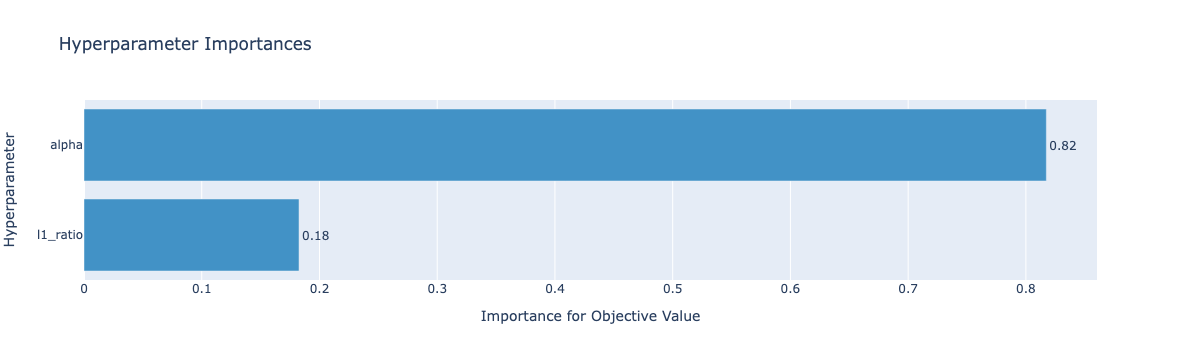

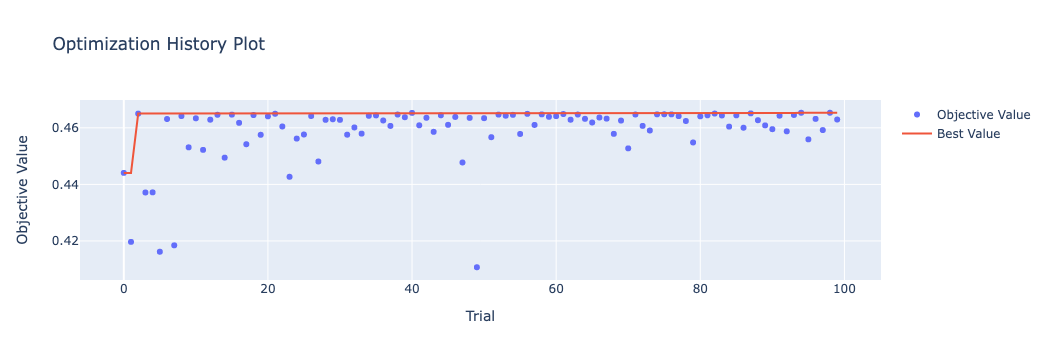

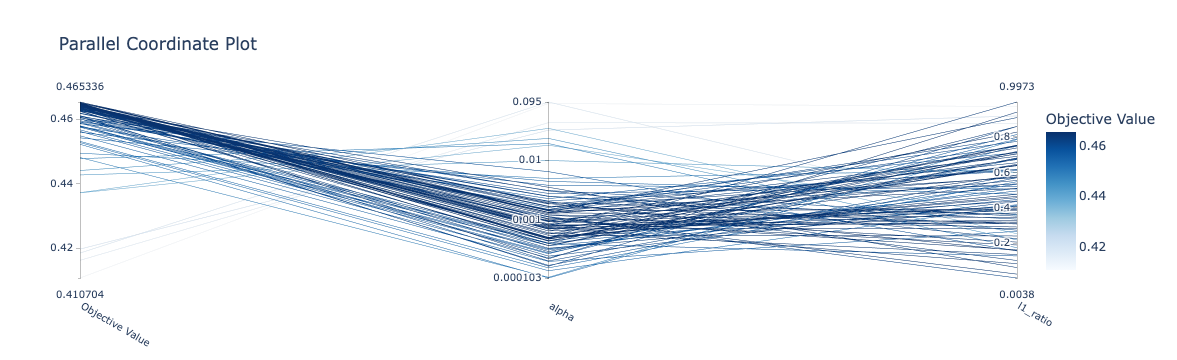

In [15]:
plot_param_importances(glm_study)
plot_optimization_history(glm_study)
plot_parallel_coordinate(glm_study)

if clargs["SAVE"]["PLOT"]:
  plot_param_importances(glm_study).write_image(f"{clargs['SAVE']['PFX']}-GLM-optuna-param-imp.png", scale=4)
  plot_optimization_history(glm_study).write_image(f"{clargs['SAVE']['PFX']}-GLM-optuna-history.png", scale=4)
  plot_parallel_coordinate(glm_study).write_image(f"{clargs['SAVE']['PFX']}-GLM-optuna-parallel.png", scale=4)

In [16]:
nopenalty = {"random_state":12345, "max_iter":1000, "fit_intercept":True, "penalty":"none"}

if len(clargs["TINY_MODEL"])>0:
  use_ind = np.arange(varmap_df.shape[0])
else:
  use_ind = np.where(np.abs(glm_obj.best_model.coef_)>1E-3)[1]

glm_model = LogisticRegression(**nopenalty).fit(Xs["train"][:,use_ind], ys["train"])

del nopenalty

In [17]:
coef_df = pd.concat([pd.DataFrame([["const","c","Intercept"]], columns=["code_type","code","code_desc"]),
                      varmap_df.loc[use_ind,["code_type","code","code_desc"]]], axis=0, ignore_index=True)

coef_df["coef"] = np.concatenate((glm_model.intercept_,glm_model.coef_[0]))
coef_df.sort_values(by="coef", key=abs, ascending=False, inplace=True)
coef_df.head(20)

code_type              code                                      code_desc      coef
0      const                 c                                      Intercept -0.496433
41      RACE  AFRICAN AMERICAN                          RACE AFRICAN AMERICAN  0.407215
13       ETG            350300  External eye infection, except conjunctivitis -0.113234
22       ETG            602300                               Induced abortion -0.105287
42      RACE         CAUCASIAN                                 RACE CAUCASIAN  0.101656
1        AGE          (18, 30]                                   AGE (18, 30] -0.092841
5        ETG            163000                                       Diabetes  0.086893
24       ETG            633900           Monilial infection of vagina (yeast) -0.077212
30       ETG            666700                                           Acne -0.073594
33       ETG            668200                 Non-malignant neoplasm of skin -0.065582
2        AGE          (30, 35]                                   AGE (30, 35] -0.062640
10       ETG            208900                     Other hematologic diseases  0.056409
36       ETG            715101            Orthopedic deformity - foot & ankle -0.056313
8        ETG            164900                                    Dehydration -0.047245
14       ETG            388100                                   Hypertension  0.046382
37       ETG            779100  Immunization encounter, professional services  0.046081
23       ETG            609900                     Obstetric signs & symptoms  0.041136
7        ETG            164800                                        Obesity  0.039960
6        ETG            164300                     Female sex gland disorders  0.039525
27       ETG            635300         Other diseases of female genital tract  0.038523

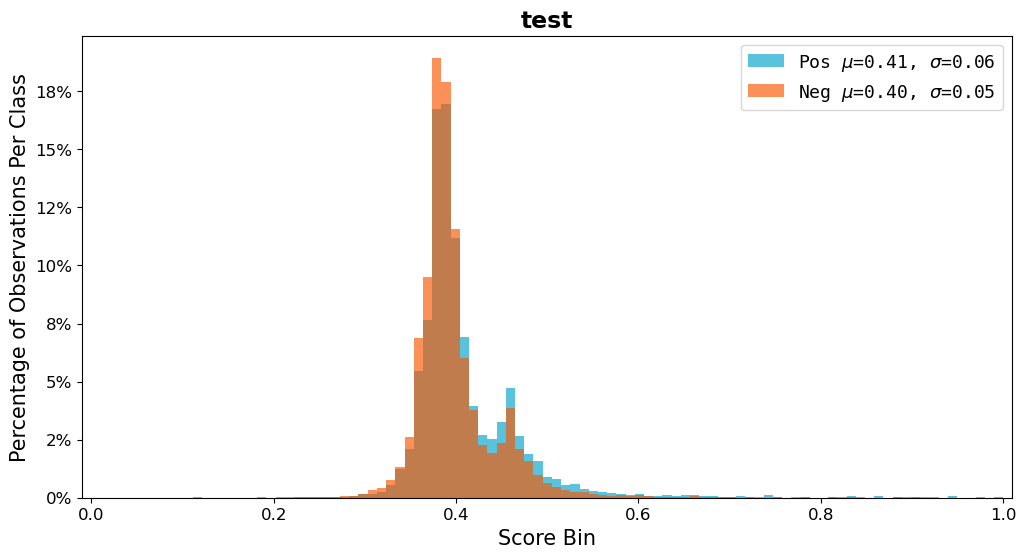

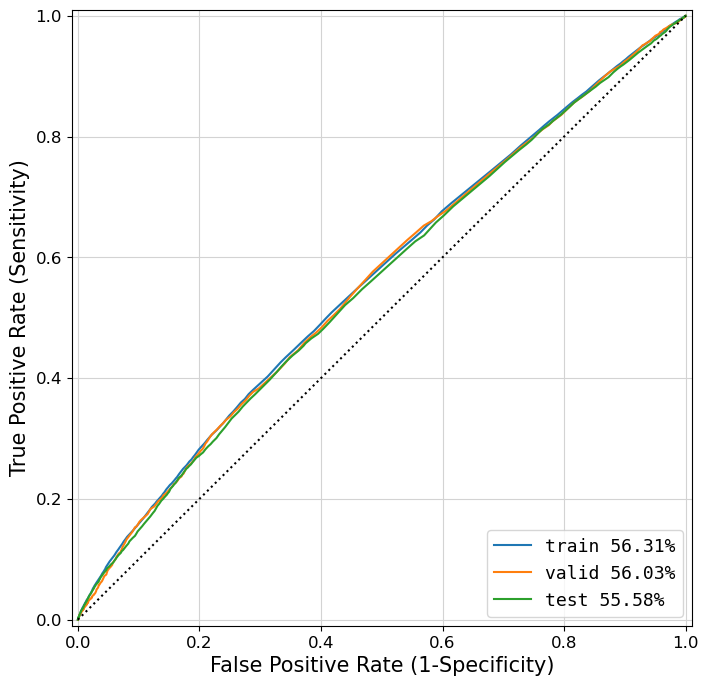

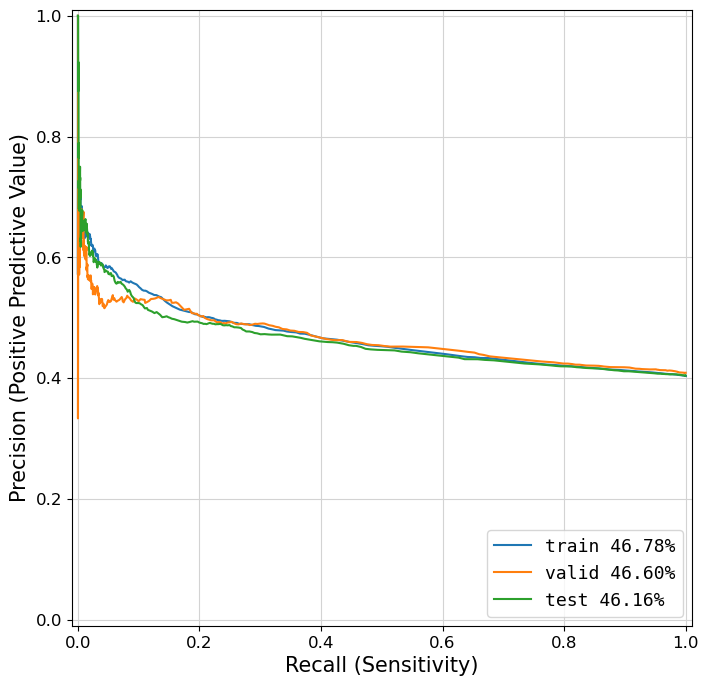

In [18]:
glm_metrics = BinaryLabelMetrics()

for x in["train","valid","test"]:
  glm_metrics.addModel(x, pd.DataFrame({"label":ys[x], "score":glm_model.predict_proba(Xs[x][:,use_ind])[:,1]}))

glm_metrics.plot(chart_types=[1], model_names=["test"])
glm_metrics.plotROC(chart_types=[1,2], params={"legloc":4, "addsz":False})

if clargs["SAVE"]["PLOT"]:
  glm_metrics.plot(chart_types=[1], model_names=["test"], params={"save":True, "prefix":f"{clargs['SAVE']['PFX']}-GLM-"})
  glm_metrics.plotROC(chart_types=[1,2], params={"legloc":4, "addsz":False, "save":True, "prefix":f"{clargs['SAVE']['PFX']}-GLM-"})

del glm_metrics, x

In [19]:
del glm_model, glm_obj, glm_study

#### Boosted Trees Using LightGBM

In [20]:
class OptunaGBM:
  
  def __init__(self):
    self.best_booster = None
    self._booster = None
    
    self.lgb_prm = {      
      "objective": "binary",
      "metric": "average_precision",
      "verbose": -1,
      "nthreads": 8,
      "boosting_type": "gbdt",
      "force_row_wise": True,
      "min_gain_to_split": 1.,
    }
  
  def __call__(self, trial):
    lgb_prm = self.lgb_prm | \
      {
        "learning_rate": trial.suggest_float("learning_rate", 1E-3, .3),
        "max_depth": trial.suggest_int("max_depth", 3, 6, step=1),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 300, 600, step=10),
        "num_leaves": trial.suggest_int("num_leaves", 100, 300, step=5),
        "lambda_l1": trial.suggest_float("lambda_l1", 1E-3, .6),                       #alpha (low)
        "lambda_l2": trial.suggest_float("lambda_l2", .5, 3.),                         #lambda (high)
        "feature_fraction": trial.suggest_float("feature_fraction", .3, .7, step=.01), #colsample_bytree
        "bagging_fraction": trial.suggest_float("bagging_fraction", .5, .8, step=.01), #subsample
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 3, step=1),
      }
    
    dtrain = lgb.Dataset(Xs["train"], ys["train"])
    dvalid = lgb.Dataset(Xs["valid"], ys["valid"])
    
    results = dict()
    early_stop = lgb.early_stopping(10, first_metric_only=False, verbose=False)
    self._booster = lgb.train(lgb_prm, dtrain, valid_sets=[dvalid], num_boost_round=500, 
                            callbacks=[early_stop,lgb.record_evaluation(results)])
    
    trial.set_user_attr("niter", self._booster.best_iteration)
    return results["valid_0"]["average_precision"][-1]
  
  def callback(self, study, trial) -> None:
    if study.best_trial==trial:
      print(f"{study.best_trial.number} ({study.best_trial.values[0]:.3f})", end=" ", flush=True)
      self.best_booster = self._booster
      return
    if trial.number%5==0:
      print(f"{trial.number}", end=" ", flush=True)

In [21]:
gbm_obj = OptunaGBM()
study_args = dict(study_name="preg", direction="maximize",
  pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=15, interval_steps=5),
  sampler=optuna.samplers.TPESampler(seed=54321)
)

study_opt_args = dict(n_trials=clargs["OPTUNA"]["TRIALS"], callbacks=[gbm_obj.callback])
print(f"best trial:", end=" ", flush=True)
gbm_study = optuna.create_study(**study_args)
gbm_study.optimize(gbm_obj, **study_opt_args)

best trial: 0 (0.473) 2 (0.474) 3 (0.474) 4 (0.477) 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 (0.477) 95 

In [22]:
study_df = gbm_study.trials_dataframe(attrs=("params","user_attrs","value","duration"))
for y in ["params","user_attrs"]:
  study_df.columns = [x[1+len(y):] if x.startswith(y) else x for x in study_df.columns]
study_df["duration"] = study_df["duration"].apply(lambda x:x.total_seconds())
with pd.option_context("display.max_rows",10, "display.float_format","{:.4f}".format):
  print(study_df.sort_values("value", ascending=False))
print(f"  cpu time: {study_df['duration'].sum()/60:.1f}min")

del y

    bagging_fraction  bagging_freq  feature_fraction  lambda_l1  lambda_l2  ...  min_data_in_leaf  num_leaves  niter  value  duration
90            0.7400             2            0.4300     0.2095     0.8064  ...               430         135    171 0.4769    1.0788
98            0.7300             3            0.4700     0.2582     0.7991  ...               520         110    162 0.4768    0.8405
4             0.7000             1            0.5700     0.2736     1.9070  ...               490         230     53 0.4768    0.2371
27            0.7300             2            0.3500     0.0224     0.5230  ...               520         165     56 0.4768    0.4152
28            0.7100             1            0.4600     0.0022     0.6149  ...               530         170     81 0.4765    0.4320
..               ...           ...               ...        ...        ...  ...               ...         ...    ...    ...       ...
25            0.6800             2            0.3000     0.254

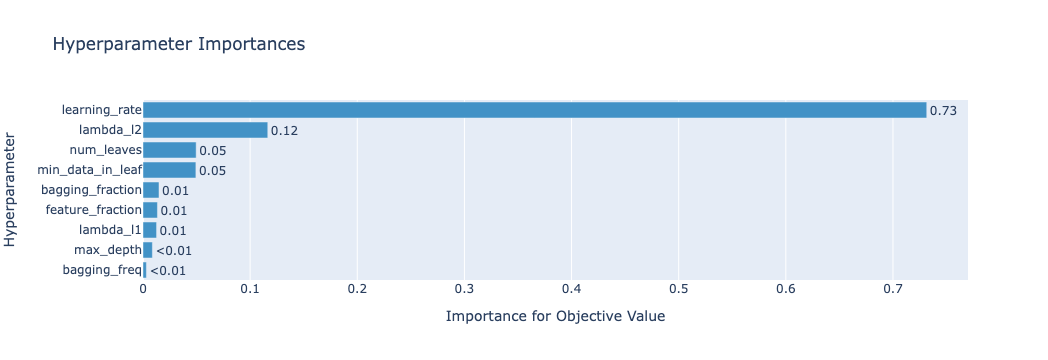

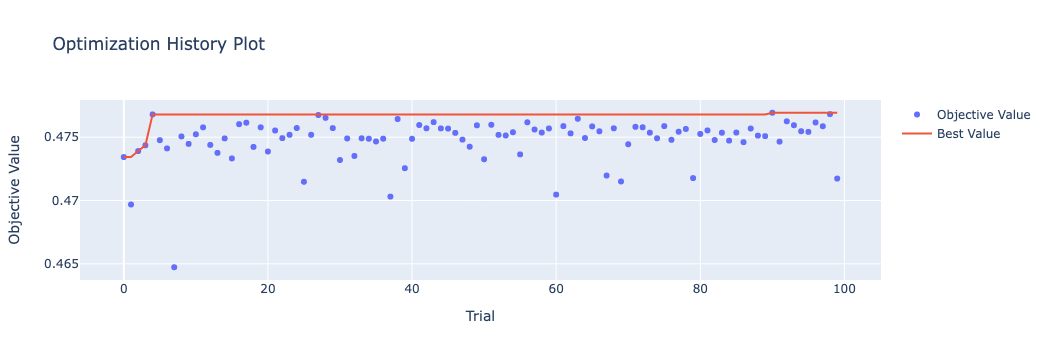

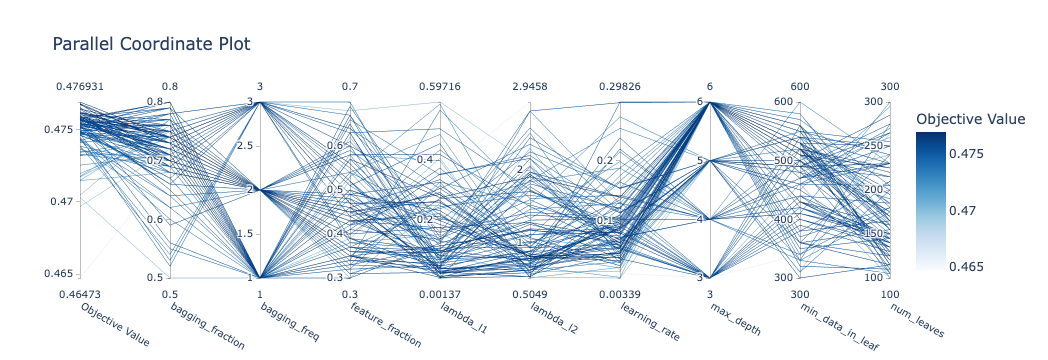

In [23]:
plot_param_importances(gbm_study)
plot_optimization_history(gbm_study)
plot_parallel_coordinate(gbm_study)

if clargs["SAVE"]["PLOT"]:
  plot_param_importances(gbm_study).write_image(f"{clargs['SAVE']['PFX']}-GBM-optuna-param-imp.png", scale=4)
  plot_optimization_history(gbm_study).write_image(f"{clargs['SAVE']['PFX']}-GBM-optuna-history.png", scale=4)
  plot_parallel_coordinate(gbm_study).write_image(f"{clargs['SAVE']['PFX']}-GBM-optuna-parallel.png", scale=4)

In [24]:
gbm_model = gbm_obj.best_booster
varimp_df = pd.DataFrame({"field":gbm_model.feature_name(), 
      "gain":gbm_model.feature_importance("gain"), "split":gbm_model.feature_importance("split")
  })
varimp_df = varimp_df.loc[varimp_df["split"]>0].reset_index()

varimp_df["varid"] = varimp_df["field"].str[7:].astype(int)
varimp_df = pd.merge(varimp_df, varmap_df[["varid","code_type","code","code_desc"]], on="varid", how="left")
varimp_df = varimp_df[["code_type","code","gain","split","code_desc"]]

varimp_df.sort_values("gain", ascending=False, ignore_index=True, inplace=True)
varimp_df[["gain","split"]] = varimp_df[["gain","split"]].applymap("{:,.0f}".format); varimp_df.head(20)

code_type              code   gain split                                                        code_desc
0        ETG            163000  2,988    76                                                         Diabetes
1       RACE  AFRICAN AMERICAN  2,396    56                                            RACE AFRICAN AMERICAN
2        ETG            164800  2,103    96                                                          Obesity
3        ETG            388100  1,277    69                                                     Hypertension
4        ETG            438800    698    68                                                           Asthma
5        ETG            635100    680    73                           Conditions associated with infertility
6        ETG            780000    583    47               Minor specific procedures not classified elsewhere
7        ETG            780100    564    44                     Other preventative & administrative services
8        AGE          (18, 30]    362    72                                                     AGE (18, 30]
9        ETG            666700    308    28                                                             Acne
10       ETG            779100    293    48                    Immunization encounter, professional services
11       ETG            164300    267    30                                       Female sex gland disorders
12       ETG            208900    258    25                                       Other hematologic diseases
13       ETG            869900    250    80  Isolated signs, symptoms & non-specific diagnoses or conditions
14       ETG            403200    249    31                                Rhinitis, allergic & non-allergic
15       ETG            271600    239    29                                            Other drug dependence
16       ETG            635300    230    39                           Other diseases of female genital tract
17       ETG            639900    225    46                                   Gynecological signs & symptoms
18       ETG            403100    219    30                          Tonsillitis, adenoiditis or pharyngitis
19       ETG            479900    192    57                       Gastroenterology diseases signs & symptoms

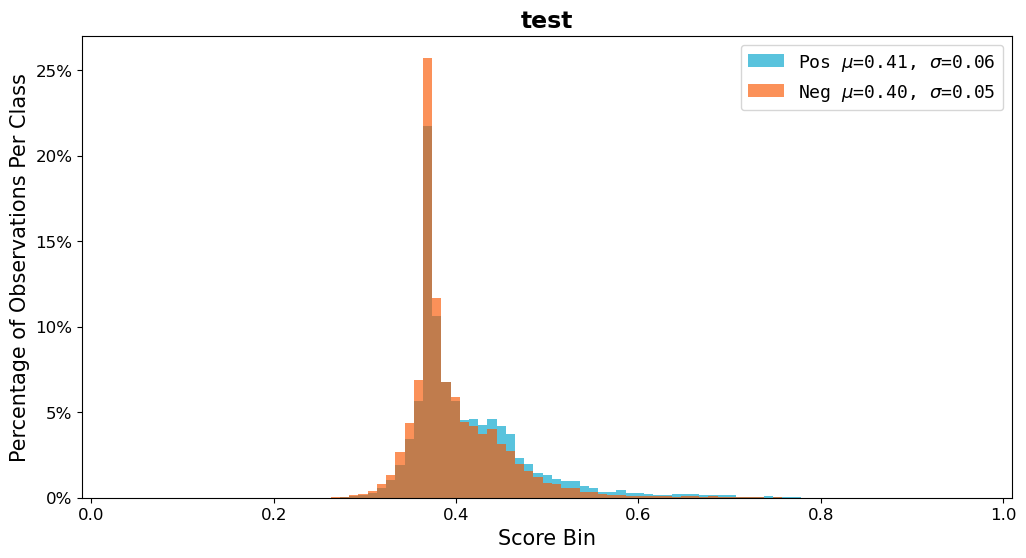

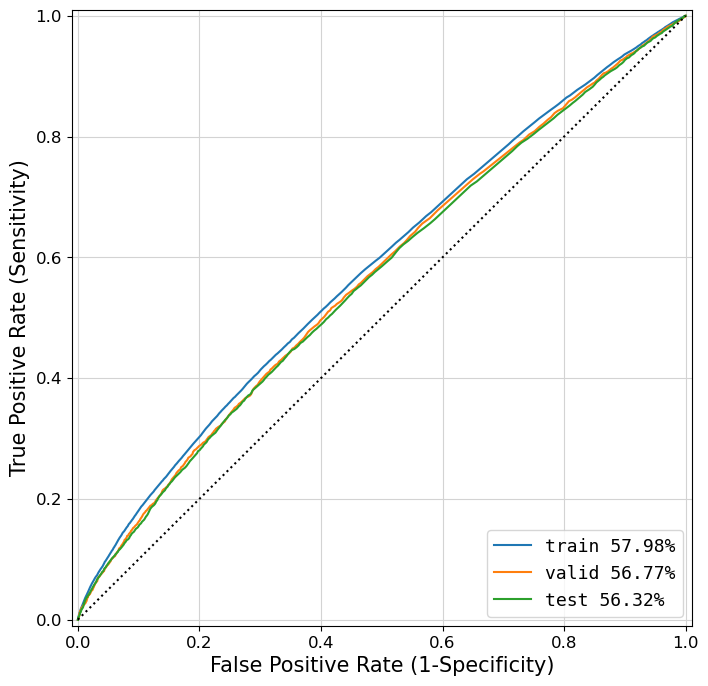

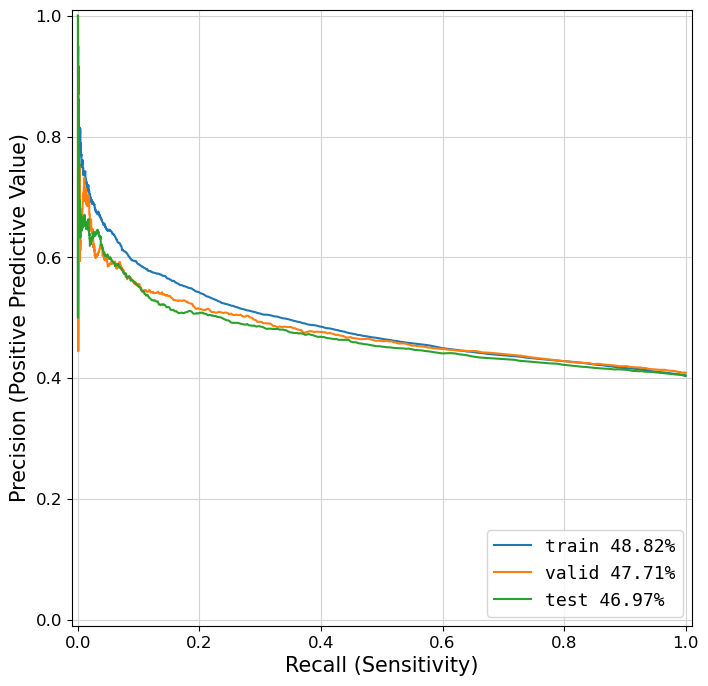

In [25]:
gbm_metrics = BinaryLabelMetrics()
for x in["train","valid","test"]:
  gbm_metrics.addModel(x, pd.DataFrame({"label":ys[x], "score":gbm_model.predict(Xs[x])}))

gbm_metrics.plot(chart_types=[1], model_names=["test"])
gbm_metrics.plotROC(chart_types=[1,2], params={"legloc":4, "addsz":False})

if clargs["SAVE"]["PLOT"]:
  gbm_metrics.plot(chart_types=[1], model_names=["test"], params={"save":True, "prefix":f"{clargs['SAVE']['PFX']}-GBM-"})
  gbm_metrics.plotROC(chart_types=[1,2], params={"legloc":4, "addsz":False, "save":True, "prefix":f"{clargs['SAVE']['PFX']}-GBM-"})

del gbm_metrics, x

#### Shapley Values

* variables are ranked in decscending order based on feature importance (y-axis)
* for a variable (along x-axis)
  - each dot represents an observation (row)
  - position along x-axis is the shap value of that feature for that observation (shap_trn[i,j])
  - color shows whether whether that feature was high or low for that row of the dataset (smat_trn[i,.])

In [26]:
explainer = shap.TreeExplainer(gbm_model, data=Xs["train"].toarray()
                                , feature_perturbation="interventional" , model_output="probability")
shap_values = explainer.shap_values(Xs["train"].toarray())

100%|===================| 93402/93649 [03:55<00:00]        

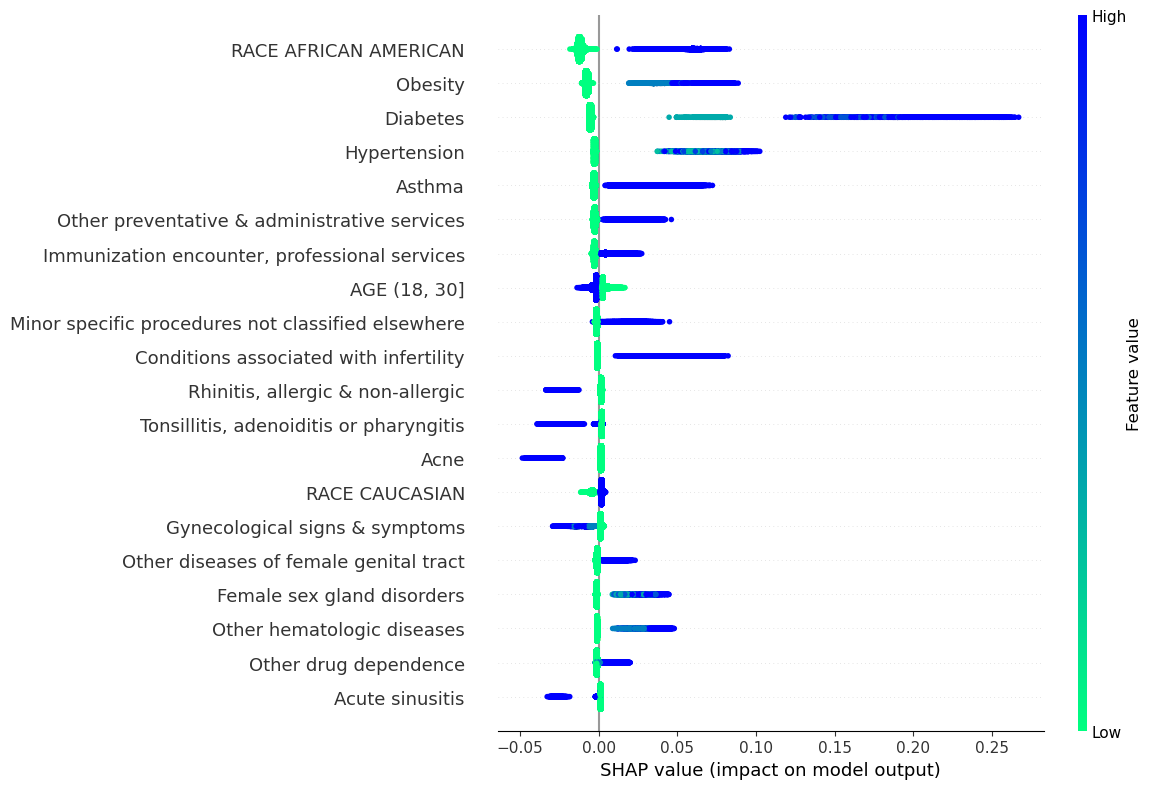

In [27]:
fig = shap.summary_plot(shap_values, Xs["train"].toarray(), feature_names=varmap_df["code_desc"], plot_type="dot", 
                          cmap=plt.get_cmap("winter_r"), max_display=20, plot_size=(12,8), show=False)

if clargs["SAVE"]["PLOT"]:
  plt.savefig(f"{clargs['SAVE']['PFX']}-GBM-shap.png", dpi=600)

In [28]:
del gbm_model, gbm_obj, gbm_study